In [1]:
import numpy as np

In [2]:
def entry_transform(number,N):
    i = int(number/N)
    j = number-i*N
    return i,j

In [3]:
def create_neighs():
    even_neighbours = [[0,1],[1,0],[1,-1],[0,-1],[-1,-1],[-1,0]]
    odd_neighbours = [[0,1],[1,0],[1,1],[0,-1],[-1,0],[-1,1]]
    neighs = [even_neighbours,odd_neighbours]  
    return neighs

In [36]:
class Lattice:
    def __init__(self,N, particle_number, Beta):
        #create the empty lattice
        lattice_matrix = np.zeros(N*N).reshape((N,N))

        #fill the lattice with particle_number particles
        part_positions = np.random.choice(a = np.arange(N*N), size = particle_number, replace = False)

        #now transform the particle positions to fill in the lattice matrix
        for k in range(particle_number):
            i,j = entry_transform(part_positions[k],N)
            lattice_matrix[i,j] = 1 #place particle in the correct position
        
        self.lattice_matrix = lattice_matrix 
        self.size = N 
        self.particle_number = particle_number
        self.temp = Beta
        

    def int_energy(self,i,j):
        #calculate the energy of the current configuration by counting the number of neighbouring particles
        neighs = create_neighs()

        #size of the lattice
        N = self.size
        
        #calculate the energy of the electron configuration
        energy = 0
        #iterate through the neighbours
        for neigh in neighs[i%2]:
            neigh_i, neigh_j = (i+neigh[0])%N, (j+neigh[1])%N
            energy += self.lattice_matrix[neigh_i,neigh_j]
        return energy
        
    def new_configurations(self):
        neighs = create_neighs()
        
        Beta = self.temp
        N = self.size
        lattice = self.lattice_matrix
        
        #list all the possible configurations and the transition rates here
        new_configs = []
        rates = []
        #iterate through the lattice
        for i in range(N):
            for j in range(N):
                
                if lattice[i,j] == 1: #there is a particle in the lattice
                    E_old = self.int_energy(i,j) #calculate the energy of the old configuration
                    
                    for neigh in neighs[i%2]: #iterate through the neighbours
                        neigh_i, neigh_j = (i+neigh[0])%N, (j+neigh[1])%N #position of the neighbouring site in the lattice
                        #then if the neighbour is empty we can hop into it
                        if lattice[neigh_i,neigh_j] == 0:
                            #calculate the energy for this empty neighbouring site
                            E_new = self.int_energy(neigh_i,neigh_j)-1
                            rate = np.exp(-(E_old-E_new)*Beta)
                            new_configs.append([i,j,neigh_i,neigh_j,E_old,E_new])
                            rates.append(rate)
                            
        return new_configs, rates
    
    def update_lattice(self, i, j, new_i, new_j):
        lattice = self.lattice_matrix

        #destroy particle at site i,j
        lattice[i, j] = 0

        #and recreate the particle at site new_i,new_j
        lattice[new_i, new_j] = 1

        #update the lattice matrix
        self.lattice_matrix = lattice


    def find_transition(self, new_configs, rates):
        #from the possible new configurations randomly choose one and carry it out
        Beta = self.temp
        N = self.size
        lattice = self.lattice_matrix
        
        #total rate/"partition function"
        tot_rate = sum(rates)

        u = np.random.random()
        val = u*tot_rate

        l = -1
        while val > 0:
            l += 1
            val -= rates[l]
            
        #we need to carry out the l-th transition
        #new configuration will be this
        chosen_config = new_configs[l] 
        i, j, new_i, new_j = chosen_config[0], chosen_config[1], chosen_config[2], chosen_config[3]
        
        #update the lattice according to the new configuration
        self.update_lattice(i = i, j = j, new_i = new_i, new_j = new_j)

    def correlations(self):
        neighs = create_neighs()

        corr = 0

        N = self.size
        lattice = self.lattice_matrix
        
        for i in range(N):
            for j in range(N):
                for neigh in neighs[i%2]: #iterate through the neighbours
                    neigh_i, neigh_j = (i+neigh[0])%N, (j+neigh[1])%N #position of the neighbour 
                    corr += lattice[i,j]*lattice[neigh_i,neigh_j] #add the correlations 

        return corr/2 #avoid double counting

In [37]:
def simulate(Lattice, it_num): 
    corrs = []
    corrs.append(Lattice.correlations())
    
    #do it_num iterations
    for n in range(it_num):
        #create a new configuration with transition rates
        newconfigs, rates = Lattice.new_configurations()
        
        #update the lattice according to the transition rates
        Lattice.find_transition(new_configs = newconfigs, rates = rates)
        
        #add the new correlations to the corrs list
        corrs.append(Lattice.correlations())
        
    return np.array(corrs)

In [43]:
import matplotlib.pyplot as plt

In [52]:
N = 40
particle_number = int(N*N/2)
Beta = 1
Test_lattice = Lattice(N = N, particle_number = particle_number, Beta = Beta)

In [53]:
it_num = 20000

cors = simulate(Lattice = Test_lattice, it_num = it_num)

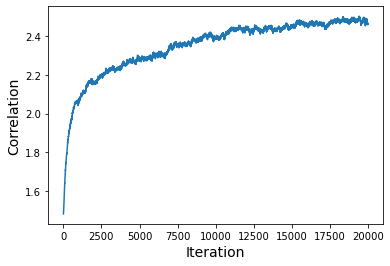

In [54]:
plt.plot(cors/particle_number)
plt.xlabel("Iteration",fontsize = 14)
plt.ylabel("Correlation", fontsize = 14)
plt.show()

In [55]:
N = 40
particle_number = int(N*N/2)
Beta = 0.1
Test_lattice = Lattice(N = N, particle_number = particle_number, Beta = Beta)

In [56]:
it_num = 20000

cors = simulate(Lattice = Test_lattice, it_num = it_num)

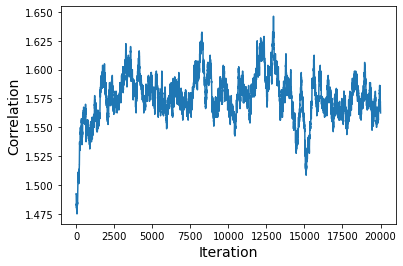

In [57]:
plt.plot(cors/particle_number)
plt.xlabel("Iteration",fontsize = 14)
plt.ylabel("Correlation", fontsize = 14)
plt.show()

In [58]:
def transition_point_finder(Betas, N, particle_number, it_num):
    final_corr = []
    for Beta in Betas:
        current_lattice = Lattice(N = N, particle_number = particle_number, Beta = Beta)
        final_corr.append(simulate(Lattice = current_lattice, it_num = it_num))